# Model klasyfikujący sekwencje

Klasyczny ML na cechach sekwencji:
- ekstrakcja cech z całej sekwencji (np. min/max/średnia/odchylenie dla
współrzędnych i prędkości, statystyki kątów),
- klasyfikator: SVM, Random Forest, Gradient Boosting itp.

⚠️ Należy (jednorazowo) doinstalować biblioteke scikit-learn:<br>

In [ ]:
%pip install scikit-learn

  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.9 MB 4.2 MB/s eta 0:00:02
   -------------- ------------------------- 3.1/8.9 MB 9.2 MB/s eta 0:00:01
   ------------------------ --------------- 5.5/8.9 MB 10.2 MB/s eta 0:00:01
   ----------------------------------- ---- 7.9/8.9 MB 10.4 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 9.5 MB/s eta 0:00:00
Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- ----

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, log_loss, recall_score, f1_score, precision_score
from sklearn.neural_network import MLPClassifier

### Wczytanie danych

In [2]:
data_path = '/content/dataset_urfall.npz'

if not os.path.exists(data_path):
    print(f"BŁĄD: Nie znaleziono pliku {data_path}")
else:
    print(f"Wczytuje dane z {data_path}...")
    with np.load(data_path) as data:
        sequences = data['sequences']
        X = data['X'] # znormalizowane punkty po preprocessingu
        y = data['y'] # etykiety (0 - stoi, 1 - leży)

    print(f"Wczytano {len(X)} próbek.")

print(f"\nKształt danych X (oryginalny): {X.shape}")
print(f"Kształt danych y: {y.shape}")
print(f"Liczba sekwencji: {len(np.unique(sequences))}")

# zmiana (N, 17, 2) -> (N, 34)
X = X.reshape(X.shape[0], -1)
print(f"\nKształt danych X (po reshape): {X.shape}")

Wczytuje dane z /content/dataset_urfall.npz...
Wczytano 9627 próbek.

Kształt danych X (oryginalny): (9627, 17, 2)
Kształt danych y: (9627,)
Liczba sekwencji: 69

Kształt danych X (po reshape): (9627, 34)


# Walidacja modeli Leave-One-Group-Out

## Model Random Forest 🌲

In [15]:
# tablice do zbierania wyników
accuracies_rf = []
losses_rf = []
recalls_rf = []
all_y_trues_rf = []
all_y_preds_rf = []

# obiekt Leave-One-Group-Out (w skrócie LOGO)
LOGO = LeaveOneGroupOut()

print("Rozpoczęcie walidacji dla modelu RandomForest...")

for i, (train_idx, test_idx) in enumerate(tqdm(LOGO.split(X, y, sequences), total=len(np.unique(sequences)))):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # tworzenie i uczenie modelu
    rf_model = RandomForestClassifier(
        n_estimators=100,
        random_state=67,
        n_jobs=-1
        )
    rf_model.fit(X_train, y_train)

    # ewaluacja modelu (predykcje)
    y_pred_rf = rf_model.predict(X_test)
    # (prawdopodbieństwo)
    y_proba_rf = rf_model.predict_proba(X_test)

    # miary jakości modelu
    rf_acc = accuracy_score(y_test, y_pred_rf)
    accuracies_rf.append(rf_acc)
    # log loss
    rf_loss = log_loss(y_test, y_proba_rf, labels=[0, 1])
    losses_rf.append(rf_loss)
    # recall
    rf_recall = recall_score(y_test, y_pred_rf, pos_label=1, zero_division=0)
    recalls_rf.append(rf_recall)

    current_seq_name = sequences[test_idx][0]

    print(f"\n   Wideo: {current_seq_name}")
    print(f"   Acc: {rf_acc:.3f} | Loss: {rf_loss:.3f} | Recall: {rf_recall:.3f}")

    all_y_trues_rf.extend(y_test)
    all_y_preds_rf.extend(y_pred_rf)

print("\nWalidacja zakończona.")

Rozpoczęcie walidacji dla modelu RandomForest...


  1%|▏         | 1/69 [00:04<04:57,  4.37s/it]


   Wideo: adl-01
   Acc: 0.938 | Loss: 0.129 | Recall: 0.000


  3%|▎         | 2/69 [00:09<05:06,  4.57s/it]


   Wideo: adl-02
   Acc: 0.987 | Loss: 0.120 | Recall: 0.000


  4%|▍         | 3/69 [00:15<05:52,  5.35s/it]


   Wideo: adl-03
   Acc: 0.706 | Loss: 0.378 | Recall: 0.000


  6%|▌         | 4/69 [00:19<05:24,  4.99s/it]


   Wideo: adl-04
   Acc: 0.907 | Loss: 0.130 | Recall: 0.000


  7%|▋         | 5/69 [00:25<05:36,  5.26s/it]


   Wideo: adl-05
   Acc: 1.000 | Loss: 0.026 | Recall: 0.000


  9%|▊         | 6/69 [00:30<05:28,  5.22s/it]


   Wideo: adl-06
   Acc: 0.981 | Loss: 0.093 | Recall: 0.000


 10%|█         | 7/69 [00:35<05:08,  4.98s/it]


   Wideo: adl-07
   Acc: 1.000 | Loss: 0.001 | Recall: 0.000


 12%|█▏        | 8/69 [00:40<05:16,  5.19s/it]


   Wideo: adl-08
   Acc: 1.000 | Loss: 0.004 | Recall: 0.000


 13%|█▎        | 9/69 [00:45<04:57,  4.96s/it]


   Wideo: adl-09
   Acc: 1.000 | Loss: 0.036 | Recall: 0.000


 14%|█▍        | 10/69 [00:50<05:02,  5.13s/it]


   Wideo: adl-10
   Acc: 0.996 | Loss: 0.061 | Recall: 0.990


 16%|█▌        | 11/69 [00:55<04:48,  4.97s/it]


   Wideo: adl-11
   Acc: 1.000 | Loss: 0.031 | Recall: 1.000


 17%|█▋        | 12/69 [00:59<04:34,  4.82s/it]


   Wideo: adl-12
   Acc: 1.000 | Loss: 0.046 | Recall: 0.000


 19%|█▉        | 13/69 [01:05<04:42,  5.05s/it]


   Wideo: adl-13
   Acc: 0.921 | Loss: 0.168 | Recall: 0.000


 20%|██        | 14/69 [01:09<04:27,  4.86s/it]


   Wideo: adl-14
   Acc: 1.000 | Loss: 0.019 | Recall: 0.000


 22%|██▏       | 15/69 [01:14<04:14,  4.71s/it]


   Wideo: adl-15
   Acc: 0.977 | Loss: 0.046 | Recall: 0.000


 23%|██▎       | 16/69 [01:20<04:38,  5.26s/it]


   Wideo: adl-16
   Acc: 0.973 | Loss: 0.103 | Recall: 0.000


 25%|██▍       | 17/69 [01:25<04:30,  5.20s/it]


   Wideo: adl-17
   Acc: 0.910 | Loss: 0.148 | Recall: 0.000


 26%|██▌       | 18/69 [01:31<04:31,  5.31s/it]


   Wideo: adl-18
   Acc: 0.954 | Loss: 0.117 | Recall: 0.000


 28%|██▊       | 19/69 [01:35<04:13,  5.07s/it]


   Wideo: adl-19
   Acc: 0.868 | Loss: 0.204 | Recall: 0.000


 29%|██▉       | 20/69 [01:40<03:58,  4.87s/it]


   Wideo: adl-20
   Acc: 0.947 | Loss: 0.113 | Recall: 0.000


 30%|███       | 21/69 [01:45<04:05,  5.12s/it]


   Wideo: adl-21
   Acc: 0.912 | Loss: 0.171 | Recall: 0.705


 32%|███▏      | 22/69 [01:50<03:51,  4.92s/it]


   Wideo: adl-22
   Acc: 0.815 | Loss: 0.262 | Recall: 0.486


 33%|███▎      | 23/69 [01:55<03:41,  4.82s/it]


   Wideo: adl-24
   Acc: 1.000 | Loss: 0.005 | Recall: 0.000


 35%|███▍      | 24/69 [02:00<03:48,  5.09s/it]


   Wideo: adl-25
   Acc: 1.000 | Loss: 0.000 | Recall: 0.000


 36%|███▌      | 25/69 [02:05<03:35,  4.89s/it]


   Wideo: adl-26
   Acc: 1.000 | Loss: 0.002 | Recall: 0.000


 38%|███▊      | 26/69 [02:10<03:39,  5.10s/it]


   Wideo: adl-27
   Acc: 1.000 | Loss: 0.000 | Recall: 0.000


 39%|███▉      | 27/69 [02:16<03:37,  5.18s/it]


   Wideo: adl-28
   Acc: 1.000 | Loss: 0.121 | Recall: 0.000


 41%|████      | 28/69 [02:20<03:23,  4.97s/it]


   Wideo: adl-29
   Acc: 1.000 | Loss: 0.000 | Recall: 0.000


 42%|████▏     | 29/69 [02:26<03:25,  5.13s/it]


   Wideo: adl-30
   Acc: 0.875 | Loss: 0.349 | Recall: 0.779


 43%|████▎     | 30/69 [02:30<03:10,  4.87s/it]


   Wideo: adl-31
   Acc: 0.800 | Loss: 0.403 | Recall: 0.632


 45%|████▍     | 31/69 [02:35<03:05,  4.89s/it]


   Wideo: adl-32
   Acc: 1.000 | Loss: 0.047 | Recall: 1.000


 46%|████▋     | 32/69 [02:40<03:06,  5.03s/it]


   Wideo: adl-33
   Acc: 0.993 | Loss: 0.077 | Recall: 0.985


 48%|████▊     | 33/69 [02:45<02:55,  4.86s/it]


   Wideo: adl-34
   Acc: 0.888 | Loss: 0.251 | Recall: 1.000


 49%|████▉     | 34/69 [02:51<03:01,  5.19s/it]


   Wideo: adl-35
   Acc: 0.993 | Loss: 0.095 | Recall: 0.991


 51%|█████     | 35/69 [02:55<02:47,  4.93s/it]


   Wideo: adl-36
   Acc: 0.661 | Loss: 0.528 | Recall: 0.081


 52%|█████▏    | 36/69 [02:59<02:37,  4.77s/it]


   Wideo: adl-37
   Acc: 0.990 | Loss: 0.088 | Recall: 1.000


 54%|█████▎    | 37/69 [03:05<02:42,  5.07s/it]


   Wideo: adl-38
   Acc: 0.988 | Loss: 0.077 | Recall: 1.000


 55%|█████▌    | 38/69 [03:10<02:31,  4.89s/it]


   Wideo: adl-39
   Acc: 1.000 | Loss: 0.080 | Recall: 1.000


 57%|█████▋    | 39/69 [03:14<02:23,  4.80s/it]


   Wideo: adl-40
   Acc: 0.983 | Loss: 0.085 | Recall: 1.000


 58%|█████▊    | 40/69 [03:20<02:26,  5.06s/it]


   Wideo: fall-01
   Acc: 1.000 | Loss: 0.056 | Recall: 1.000


 59%|█████▉    | 41/69 [03:24<02:18,  4.93s/it]


   Wideo: fall-02
   Acc: 1.000 | Loss: 0.005 | Recall: 1.000


 61%|██████    | 42/69 [03:30<02:19,  5.17s/it]


   Wideo: fall-03
   Acc: 1.000 | Loss: 0.023 | Recall: 1.000


 62%|██████▏   | 43/69 [03:35<02:09,  4.98s/it]


   Wideo: fall-04
   Acc: 1.000 | Loss: 0.005 | Recall: 1.000


 64%|██████▍   | 44/69 [03:39<02:01,  4.88s/it]


   Wideo: fall-05
   Acc: 1.000 | Loss: 0.058 | Recall: 1.000


 65%|██████▌   | 45/69 [03:45<02:04,  5.18s/it]


   Wideo: fall-06
   Acc: 1.000 | Loss: 0.024 | Recall: 1.000


 67%|██████▋   | 46/69 [03:50<01:54,  4.99s/it]


   Wideo: fall-07
   Acc: 1.000 | Loss: 0.017 | Recall: 1.000


 68%|██████▊   | 47/69 [03:55<01:48,  4.94s/it]


   Wideo: fall-08
   Acc: 0.984 | Loss: 0.060 | Recall: 0.969


 70%|██████▉   | 48/69 [04:00<01:47,  5.10s/it]


   Wideo: fall-09
   Acc: 1.000 | Loss: 0.004 | Recall: 1.000


 71%|███████   | 49/69 [04:05<01:38,  4.94s/it]


   Wideo: fall-10
   Acc: 1.000 | Loss: 0.009 | Recall: 1.000


 72%|███████▏  | 50/69 [04:10<01:39,  5.22s/it]


   Wideo: fall-11
   Acc: 1.000 | Loss: 0.019 | Recall: 1.000


 74%|███████▍  | 51/69 [04:15<01:30,  5.05s/it]


   Wideo: fall-12
   Acc: 1.000 | Loss: 0.007 | Recall: 1.000


 75%|███████▌  | 52/69 [04:20<01:23,  4.89s/it]


   Wideo: fall-13
   Acc: 0.982 | Loss: 0.026 | Recall: 0.917


 77%|███████▋  | 53/69 [04:25<01:22,  5.17s/it]


   Wideo: fall-14
   Acc: 0.774 | Loss: 2.093 | Recall: 0.562


 78%|███████▊  | 54/69 [04:30<01:14,  5.00s/it]


   Wideo: fall-15
   Acc: 1.000 | Loss: 0.032 | Recall: 1.000


 80%|███████▉  | 55/69 [04:35<01:11,  5.09s/it]


   Wideo: fall-16
   Acc: 1.000 | Loss: 0.016 | Recall: 1.000


 81%|████████  | 56/69 [04:41<01:06,  5.11s/it]


   Wideo: fall-17
   Acc: 1.000 | Loss: 0.013 | Recall: 1.000


 83%|████████▎ | 57/69 [04:45<00:59,  4.97s/it]


   Wideo: fall-18
   Acc: 1.000 | Loss: 0.004 | Recall: 1.000


 84%|████████▍ | 58/69 [04:51<00:58,  5.33s/it]


   Wideo: fall-19
   Acc: 1.000 | Loss: 0.068 | Recall: 1.000


 86%|████████▌ | 59/69 [04:56<00:51,  5.10s/it]


   Wideo: fall-20
   Acc: 0.988 | Loss: 0.159 | Recall: 0.984


 87%|████████▋ | 60/69 [05:01<00:44,  4.97s/it]


   Wideo: fall-21
   Acc: 1.000 | Loss: 0.021 | Recall: 1.000


 88%|████████▊ | 61/69 [05:07<00:42,  5.27s/it]


   Wideo: fall-22
   Acc: 1.000 | Loss: 0.026 | Recall: 1.000


 90%|████████▉ | 62/69 [05:11<00:35,  5.07s/it]


   Wideo: fall-23
   Acc: 1.000 | Loss: 0.039 | Recall: 1.000


 91%|█████████▏| 63/69 [05:17<00:31,  5.33s/it]


   Wideo: fall-24
   Acc: 1.000 | Loss: 0.009 | Recall: 1.000


 93%|█████████▎| 64/69 [05:22<00:25,  5.14s/it]


   Wideo: fall-25
   Acc: 1.000 | Loss: 0.025 | Recall: 1.000


 94%|█████████▍| 65/69 [05:26<00:19,  4.98s/it]


   Wideo: fall-26
   Acc: 1.000 | Loss: 0.055 | Recall: 1.000


 96%|█████████▌| 66/69 [05:32<00:15,  5.27s/it]


   Wideo: fall-27
   Acc: 1.000 | Loss: 0.022 | Recall: 1.000


 97%|█████████▋| 67/69 [05:37<00:10,  5.05s/it]


   Wideo: fall-28
   Acc: 1.000 | Loss: 0.022 | Recall: 1.000


 99%|█████████▊| 68/69 [05:42<00:05,  5.13s/it]


   Wideo: fall-29
   Acc: 1.000 | Loss: 0.015 | Recall: 1.000


100%|██████████| 69/69 [05:47<00:00,  5.04s/it]


   Wideo: fall-30
   Acc: 1.000 | Loss: 0.046 | Recall: 1.000

Walidacja zakończona.


### Wyniki

==================== Random Forest ====================
Średnia dokładnośc (accuracy): 0.967
Średni Log Loss:  0.110
Średni Recall:    0.610

Raport zbiorczy (z wszystkich testów):

              precision    recall  f1-score   support

        Stoi       0.97      0.97      0.97      7330
        Leży       0.90      0.90      0.90      2297

    accuracy                           0.95      9627
   macro avg       0.94      0.93      0.93      9627
weighted avg       0.95      0.95      0.95      9627



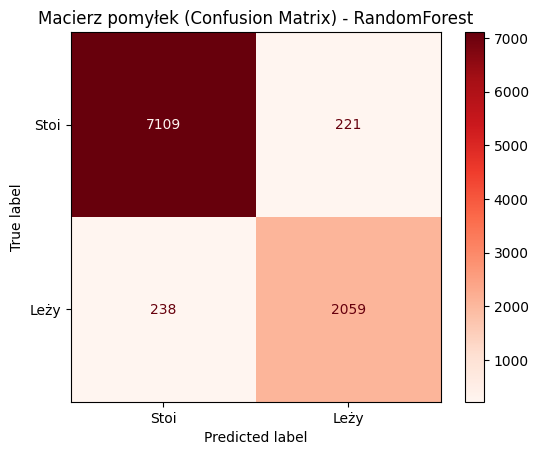

In [16]:
print(f"="*20+" Random Forest "+"="*20)

print(f"Średnia dokładnośc (accuracy): {np.mean(accuracies_rf):.3f}")
print(f"Średni Log Loss:  {np.mean(losses_rf):.3f}")
print(f"Średni Recall:    {np.mean(recalls_rf):.3f}")

print(f"\nRaport zbiorczy (z wszystkich testów):\n")
print(classification_report(all_y_trues_rf, all_y_preds_rf, target_names=['Stoi', 'Leży']))

# macierz pomyłek
cm_rf = confusion_matrix(all_y_trues_rf, all_y_preds_rf)
ConfusionMatrixDisplay(cm_rf, display_labels=['Stoi', 'Leży']).plot(cmap='Reds')
plt.title(f'Macierz pomyłek (Confusion Matrix) - RandomForest')
plt.show()

## Model SVM 📐

In [17]:
# tablice do zbierania wyników
accuracies_svm = []
losses_svm = []
recalls_svm = []
all_y_trues_svm = []
all_y_preds_svm= []

# obiekt Leave-One-Group-Out (w skrócie LOGO)
LOGO = LeaveOneGroupOut()

print("Rozpoczęcie walidacji dla modelu SVM...")

for i, (train_idx, test_idx) in enumerate(tqdm(LOGO.split(X, y, sequences), total=len(np.unique(sequences)))):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # tworzenie i uczenie modelu
    svm_model = SVC(
        C=1,
        kernel='rbf',
        probability=True,
        random_state=67
        )
    svm_model.fit(X_train, y_train)

    # ewaluacja modelu (predykcje)
    y_pred_svm = svm_model.predict(X_test)
    # (prawdopodobienstwo)
    y_proba_svm = svm_model.predict_proba(X_test)

    # miary jakości modelu
    svm_acc = accuracy_score(y_test, y_pred_svm)
    accuracies_svm.append(svm_acc)
    # log loss
    svm_loss = log_loss(y_test, y_proba_svm, labels=[0, 1])
    losses_svm.append(svm_loss)
    # recall
    svm_recall = recall_score(y_test, y_pred_svm, pos_label=1, zero_division=0)
    recalls_svm.append(svm_recall)

    current_seq_name = sequences[test_idx][0]

    print(f"\n   Wideo: {current_seq_name}")
    print(f"   Acc: {svm_acc:.3f} | Loss: {svm_loss:.3f} | Recall: {svm_recall:.3f}\n")

    all_y_trues_svm.extend(y_test)
    all_y_preds_svm.extend(y_pred_svm)

print("\nWalidacja zakończona.")

Rozpoczęcie walidacji dla modelu SVM...


  1%|▏         | 1/69 [00:02<03:13,  2.84s/it]


   Wideo: adl-01
   Acc: 1.000 | Loss: 0.025 | Recall: 0.000



  3%|▎         | 2/69 [00:05<03:10,  2.84s/it]


   Wideo: adl-02
   Acc: 1.000 | Loss: 0.042 | Recall: 0.000



  4%|▍         | 3/69 [00:09<03:34,  3.25s/it]


   Wideo: adl-03
   Acc: 1.000 | Loss: 0.057 | Recall: 0.000



  6%|▌         | 4/69 [00:12<03:19,  3.08s/it]


   Wideo: adl-04
   Acc: 1.000 | Loss: 0.008 | Recall: 0.000



  7%|▋         | 5/69 [00:15<03:10,  2.98s/it]


   Wideo: adl-05
   Acc: 1.000 | Loss: 0.006 | Recall: 0.000



  9%|▊         | 6/69 [00:17<03:04,  2.93s/it]


   Wideo: adl-06
   Acc: 1.000 | Loss: 0.002 | Recall: 0.000



 10%|█         | 7/69 [00:21<03:19,  3.21s/it]


   Wideo: adl-07
   Acc: 1.000 | Loss: 0.003 | Recall: 0.000



 12%|█▏        | 8/69 [00:24<03:08,  3.10s/it]


   Wideo: adl-08
   Acc: 1.000 | Loss: 0.005 | Recall: 0.000



 13%|█▎        | 9/69 [00:27<03:01,  3.02s/it]


   Wideo: adl-09
   Acc: 1.000 | Loss: 0.003 | Recall: 0.000



 14%|█▍        | 10/69 [00:30<02:53,  2.95s/it]


   Wideo: adl-10
   Acc: 0.993 | Loss: 0.025 | Recall: 0.980



 16%|█▌        | 11/69 [00:33<03:05,  3.19s/it]


   Wideo: adl-11
   Acc: 1.000 | Loss: 0.003 | Recall: 1.000



 17%|█▋        | 12/69 [00:36<02:54,  3.07s/it]


   Wideo: adl-12
   Acc: 1.000 | Loss: 0.013 | Recall: 0.000



 19%|█▉        | 13/69 [00:39<02:45,  2.96s/it]


   Wideo: adl-13
   Acc: 0.980 | Loss: 0.083 | Recall: 0.000



 20%|██        | 14/69 [00:42<02:40,  2.92s/it]


   Wideo: adl-14
   Acc: 1.000 | Loss: 0.009 | Recall: 0.000



 22%|██▏       | 15/69 [00:45<02:47,  3.11s/it]


   Wideo: adl-15
   Acc: 0.981 | Loss: 0.072 | Recall: 0.000



 23%|██▎       | 16/69 [00:48<02:40,  3.03s/it]


   Wideo: adl-16
   Acc: 0.991 | Loss: 0.038 | Recall: 0.000



 25%|██▍       | 17/69 [00:51<02:33,  2.95s/it]


   Wideo: adl-17
   Acc: 0.933 | Loss: 0.249 | Recall: 0.000



 26%|██▌       | 18/69 [00:54<02:27,  2.89s/it]


   Wideo: adl-18
   Acc: 0.962 | Loss: 0.133 | Recall: 0.000



 28%|██▊       | 19/69 [00:57<02:29,  2.98s/it]


   Wideo: adl-19
   Acc: 0.982 | Loss: 0.125 | Recall: 0.000



 29%|██▉       | 20/69 [01:00<02:29,  3.05s/it]


   Wideo: adl-20
   Acc: 0.943 | Loss: 0.152 | Recall: 0.000



 30%|███       | 21/69 [01:03<02:21,  2.95s/it]


   Wideo: adl-21
   Acc: 0.917 | Loss: 0.310 | Recall: 0.738



 32%|███▏      | 22/69 [01:05<02:13,  2.84s/it]


   Wideo: adl-22
   Acc: 0.802 | Loss: 0.623 | Recall: 0.403



 33%|███▎      | 23/69 [01:08<02:11,  2.86s/it]


   Wideo: adl-24
   Acc: 1.000 | Loss: 0.002 | Recall: 0.000



 35%|███▍      | 24/69 [01:12<02:20,  3.12s/it]


   Wideo: adl-25
   Acc: 1.000 | Loss: 0.001 | Recall: 0.000



 36%|███▌      | 25/69 [01:15<02:13,  3.04s/it]


   Wideo: adl-26
   Acc: 1.000 | Loss: 0.001 | Recall: 0.000



 38%|███▊      | 26/69 [01:18<02:08,  2.99s/it]


   Wideo: adl-27
   Acc: 1.000 | Loss: 0.001 | Recall: 0.000



 39%|███▉      | 27/69 [01:21<02:04,  2.96s/it]


   Wideo: adl-28
   Acc: 1.000 | Loss: 0.002 | Recall: 0.000



 41%|████      | 28/69 [01:24<02:11,  3.21s/it]


   Wideo: adl-29
   Acc: 1.000 | Loss: 0.001 | Recall: 0.000



 42%|████▏     | 29/69 [01:27<02:00,  3.02s/it]


   Wideo: adl-30
   Acc: 0.821 | Loss: 0.681 | Recall: 0.680



 43%|████▎     | 30/69 [01:30<01:54,  2.93s/it]


   Wideo: adl-31
   Acc: 0.841 | Loss: 0.549 | Recall: 0.697



 45%|████▍     | 31/69 [01:33<01:50,  2.91s/it]


   Wideo: adl-32
   Acc: 0.993 | Loss: 0.015 | Recall: 0.987



 46%|████▋     | 32/69 [01:36<01:57,  3.17s/it]


   Wideo: adl-33
   Acc: 0.993 | Loss: 0.020 | Recall: 0.985



 48%|████▊     | 33/69 [01:39<01:50,  3.06s/it]


   Wideo: adl-34
   Acc: 0.918 | Loss: 0.153 | Recall: 1.000



 49%|████▉     | 34/69 [01:42<01:44,  2.99s/it]


   Wideo: adl-35
   Acc: 0.986 | Loss: 0.010 | Recall: 0.981



 51%|█████     | 35/69 [01:45<01:38,  2.89s/it]


   Wideo: adl-36
   Acc: 0.655 | Loss: 0.892 | Recall: 0.063



 52%|█████▏    | 36/69 [01:48<01:43,  3.13s/it]


   Wideo: adl-37
   Acc: 0.997 | Loss: 0.046 | Recall: 1.000



 54%|█████▎    | 37/69 [01:51<01:36,  3.02s/it]


   Wideo: adl-38
   Acc: 0.988 | Loss: 0.020 | Recall: 0.993



 55%|█████▌    | 38/69 [01:54<01:31,  2.96s/it]


   Wideo: adl-39
   Acc: 0.995 | Loss: 0.018 | Recall: 0.987



 57%|█████▋    | 39/69 [01:57<01:27,  2.90s/it]


   Wideo: adl-40
   Acc: 0.962 | Loss: 0.093 | Recall: 0.930



 58%|█████▊    | 40/69 [02:00<01:30,  3.13s/it]


   Wideo: fall-01
   Acc: 0.992 | Loss: 0.008 | Recall: 0.979



 59%|█████▉    | 41/69 [02:03<01:26,  3.08s/it]


   Wideo: fall-02
   Acc: 1.000 | Loss: 0.002 | Recall: 1.000



 61%|██████    | 42/69 [02:06<01:21,  3.01s/it]


   Wideo: fall-03
   Acc: 1.000 | Loss: 0.007 | Recall: 1.000



 62%|██████▏   | 43/69 [02:09<01:17,  2.97s/it]


   Wideo: fall-04
   Acc: 1.000 | Loss: 0.001 | Recall: 1.000



 64%|██████▍   | 44/69 [02:13<01:18,  3.16s/it]


   Wideo: fall-05
   Acc: 1.000 | Loss: 0.012 | Recall: 1.000



 65%|██████▌   | 45/69 [02:16<01:15,  3.13s/it]


   Wideo: fall-06
   Acc: 1.000 | Loss: 0.005 | Recall: 1.000



 67%|██████▋   | 46/69 [02:18<01:09,  3.04s/it]


   Wideo: fall-07
   Acc: 1.000 | Loss: 0.004 | Recall: 1.000



 68%|██████▊   | 47/69 [02:21<01:05,  2.99s/it]


   Wideo: fall-08
   Acc: 0.967 | Loss: 0.086 | Recall: 0.938



 70%|██████▉   | 48/69 [02:25<01:06,  3.15s/it]


   Wideo: fall-09
   Acc: 1.000 | Loss: 0.002 | Recall: 1.000



 71%|███████   | 49/69 [02:28<01:03,  3.16s/it]


   Wideo: fall-10
   Acc: 1.000 | Loss: 0.003 | Recall: 1.000



 72%|███████▏  | 50/69 [02:31<00:58,  3.07s/it]


   Wideo: fall-11
   Acc: 1.000 | Loss: 0.001 | Recall: 1.000



 74%|███████▍  | 51/69 [02:34<00:54,  3.01s/it]


   Wideo: fall-12
   Acc: 1.000 | Loss: 0.002 | Recall: 1.000



 75%|███████▌  | 52/69 [02:37<00:54,  3.18s/it]


   Wideo: fall-13
   Acc: 0.982 | Loss: 0.079 | Recall: 0.917



 77%|███████▋  | 53/69 [02:40<00:50,  3.16s/it]


   Wideo: fall-14
   Acc: 0.710 | Loss: 1.098 | Recall: 0.438



 78%|███████▊  | 54/69 [02:43<00:45,  3.06s/it]


   Wideo: fall-15
   Acc: 1.000 | Loss: 0.002 | Recall: 1.000



 80%|███████▉  | 55/69 [02:46<00:42,  3.01s/it]


   Wideo: fall-16
   Acc: 1.000 | Loss: 0.003 | Recall: 1.000



 81%|████████  | 56/69 [02:50<00:40,  3.13s/it]


   Wideo: fall-17
   Acc: 1.000 | Loss: 0.002 | Recall: 1.000



 83%|████████▎ | 57/69 [02:53<00:37,  3.17s/it]


   Wideo: fall-18
   Acc: 1.000 | Loss: 0.009 | Recall: 1.000



 84%|████████▍ | 58/69 [02:56<00:33,  3.09s/it]


   Wideo: fall-19
   Acc: 1.000 | Loss: 0.002 | Recall: 1.000



 86%|████████▌ | 59/69 [02:59<00:30,  3.00s/it]


   Wideo: fall-20
   Acc: 0.825 | Loss: 0.204 | Recall: 0.778



 87%|████████▋ | 60/69 [03:02<00:27,  3.10s/it]


   Wideo: fall-21
   Acc: 1.000 | Loss: 0.002 | Recall: 1.000



 88%|████████▊ | 61/69 [03:05<00:25,  3.22s/it]


   Wideo: fall-22
   Acc: 1.000 | Loss: 0.004 | Recall: 1.000



 90%|████████▉ | 62/69 [03:08<00:21,  3.11s/it]


   Wideo: fall-23
   Acc: 1.000 | Loss: 0.002 | Recall: 1.000



 91%|█████████▏| 63/69 [03:11<00:18,  3.04s/it]


   Wideo: fall-24
   Acc: 1.000 | Loss: 0.004 | Recall: 1.000



 93%|█████████▎| 64/69 [03:14<00:15,  3.13s/it]


   Wideo: fall-25
   Acc: 1.000 | Loss: 0.007 | Recall: 1.000



 94%|█████████▍| 65/69 [03:18<00:12,  3.20s/it]


   Wideo: fall-26
   Acc: 1.000 | Loss: 0.008 | Recall: 1.000



 96%|█████████▌| 66/69 [03:21<00:09,  3.11s/it]


   Wideo: fall-27
   Acc: 1.000 | Loss: 0.001 | Recall: 1.000



 97%|█████████▋| 67/69 [03:24<00:06,  3.03s/it]


   Wideo: fall-28
   Acc: 1.000 | Loss: 0.005 | Recall: 1.000



 99%|█████████▊| 68/69 [03:27<00:03,  3.10s/it]


   Wideo: fall-29
   Acc: 1.000 | Loss: 0.001 | Recall: 1.000



100%|██████████| 69/69 [03:30<00:00,  3.05s/it]


   Wideo: fall-30
   Acc: 1.000 | Loss: 0.011 | Recall: 1.000


Walidacja zakończona.


### Wyniki

==================== SVM ====================
Średnia dokładnośc (accuracy):   0.973
Średni Log Loss:   0.088
Średni Recall:   0.601

Raport zbiorczy (z wszystkich testów): 

              precision    recall  f1-score   support

        Stoi       0.96      0.99      0.98      7330
        Leży       0.96      0.88      0.92      2297

    accuracy                           0.96      9627
   macro avg       0.96      0.93      0.95      9627
weighted avg       0.96      0.96      0.96      9627



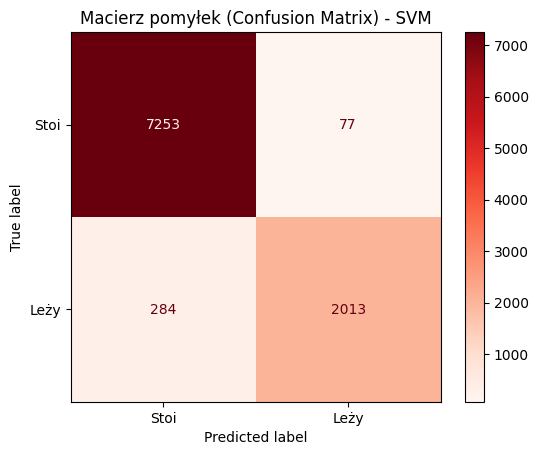

In [18]:
print(f"="*20+" SVM "+"="*20)

print(f"Średnia dokładnośc (accuracy):   {np.mean(accuracies_svm):.3f}")
print(f"Średni Log Loss:   {np.mean(losses_svm):.3f}")
print(f"Średni Recall:   {np.mean(recalls_svm):.3f}")

print(f"\nRaport zbiorczy (z wszystkich testów): \n")
print(classification_report(all_y_trues_svm, all_y_preds_svm, target_names=['Stoi', 'Leży']))

# macierz pomyłek
cm_svm = confusion_matrix(all_y_trues_svm, all_y_preds_svm)
ConfusionMatrixDisplay(cm_svm, display_labels=['Stoi', 'Leży']).plot(cmap='Reds')
plt.title(f'Macierz pomyłek (Confusion Matrix) - SVM')
plt.show()

## Model MLP 🧠

In [6]:
accuracies_mlp = []
recalls_mlp = []
losses_mlp = []
all_y_trues_mlp = []
all_y_preds_mlp = []

LOGO = LeaveOneGroupOut()

print("Rozpoczęcie walidacji dla modelu MLP...")

for i, (train_idx, test_idx) in enumerate(tqdm(LOGO.split(X, y, sequences), total=len(np.unique(sequences)))):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # tworzenie i uczenie modelu
    mlp_model = MLPClassifier(
        hidden_layer_sizes=(128),
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=67
        )
    mlp_model.fit(X_train, y_train)

    #
    y_pred_mlp = mlp_model.predict(X_test)

    #
    y_proba_mlp = mlp_model.predict_proba(X_test)

    # miary jakości
    mlp_acc = accuracy_score(y_test, y_pred_mlp)
    accuracies_mlp.append(mlp_acc)
    #
    mlp_loss = log_loss(y_test, y_proba_mlp, labels=[0, 1])
    losses_mlp.append(mlp_loss)
    #
    mlp_recall = recall_score(y_test, y_pred_mlp, pos_label=1, zero_division=0)
    recalls_mlp.append(mlp_recall)

    current_seq_name = sequences[test_idx][0]

    print(f"\n   Wideo: {current_seq_name}")
    print(f"   Acc: {mlp_acc:.3f} | Loss: {mlp_loss:.3f} | Recall: {mlp_recall:.3f}\n")

    all_y_trues_mlp.extend(y_test)
    all_y_preds_mlp.extend(y_pred_mlp)

print("\nWalidacja zakończona.")

Rozpoczęcie walidacji dla modelu MLP...


  1%|▏         | 1/69 [00:18<21:27, 18.93s/it]


   Wideo: adl-01
   Acc: 1.000 | Loss: 0.002 | Recall: 0.000



  3%|▎         | 2/69 [00:31<16:42, 14.96s/it]


   Wideo: adl-02
   Acc: 0.960 | Loss: 0.084 | Recall: 0.000



  4%|▍         | 3/69 [00:39<13:09, 11.96s/it]


   Wideo: adl-03
   Acc: 0.872 | Loss: 0.266 | Recall: 0.000



  6%|▌         | 4/69 [00:51<13:00, 12.00s/it]


   Wideo: adl-04
   Acc: 1.000 | Loss: 0.003 | Recall: 0.000



  7%|▋         | 5/69 [01:03<12:35, 11.81s/it]


   Wideo: adl-05
   Acc: 1.000 | Loss: 0.001 | Recall: 0.000



  9%|▊         | 6/69 [01:15<12:38, 12.04s/it]


   Wideo: adl-06
   Acc: 1.000 | Loss: 0.001 | Recall: 0.000



 10%|█         | 7/69 [01:27<12:16, 11.88s/it]


   Wideo: adl-07
   Acc: 1.000 | Loss: 0.000 | Recall: 0.000



 12%|█▏        | 8/69 [01:39<12:22, 12.16s/it]


   Wideo: adl-08
   Acc: 1.000 | Loss: 0.000 | Recall: 0.000



 13%|█▎        | 9/69 [01:51<11:58, 11.97s/it]


   Wideo: adl-09
   Acc: 1.000 | Loss: 0.001 | Recall: 0.000



 14%|█▍        | 10/69 [02:26<18:44, 19.06s/it]


   Wideo: adl-10
   Acc: 0.926 | Loss: 0.202 | Recall: 0.802



 16%|█▌        | 11/69 [02:50<20:04, 20.77s/it]


   Wideo: adl-11
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



 17%|█▋        | 12/69 [03:03<17:16, 18.19s/it]


   Wideo: adl-12
   Acc: 0.996 | Loss: 0.007 | Recall: 0.000



 19%|█▉        | 13/69 [03:15<15:15, 16.34s/it]


   Wideo: adl-13
   Acc: 0.960 | Loss: 0.175 | Recall: 0.000



 20%|██        | 14/69 [03:26<13:38, 14.88s/it]


   Wideo: adl-14
   Acc: 1.000 | Loss: 0.001 | Recall: 0.000



 22%|██▏       | 15/69 [03:37<12:16, 13.63s/it]


   Wideo: adl-15
   Acc: 0.985 | Loss: 0.223 | Recall: 0.000



 23%|██▎       | 16/69 [03:46<10:49, 12.25s/it]


   Wideo: adl-16
   Acc: 0.991 | Loss: 0.062 | Recall: 0.000



 25%|██▍       | 17/69 [03:59<10:52, 12.55s/it]


   Wideo: adl-17
   Acc: 0.933 | Loss: 0.318 | Recall: 0.000



 26%|██▌       | 18/69 [04:11<10:21, 12.18s/it]


   Wideo: adl-18
   Acc: 0.962 | Loss: 0.546 | Recall: 0.000



 28%|██▊       | 19/69 [04:23<10:10, 12.21s/it]


   Wideo: adl-19
   Acc: 0.882 | Loss: 0.309 | Recall: 0.000



 29%|██▉       | 20/69 [04:34<09:48, 12.00s/it]


   Wideo: adl-20
   Acc: 0.972 | Loss: 0.140 | Recall: 0.000



 30%|███       | 21/69 [04:46<09:22, 11.72s/it]


   Wideo: adl-21
   Acc: 0.941 | Loss: 0.264 | Recall: 0.803



 32%|███▏      | 22/69 [04:56<08:53, 11.35s/it]


   Wideo: adl-22
   Acc: 0.860 | Loss: 0.369 | Recall: 0.611



 33%|███▎      | 23/69 [05:08<08:51, 11.56s/it]


   Wideo: adl-24
   Acc: 1.000 | Loss: 0.000 | Recall: 0.000



 35%|███▍      | 24/69 [05:20<08:50, 11.80s/it]


   Wideo: adl-25
   Acc: 1.000 | Loss: 0.000 | Recall: 0.000



 36%|███▌      | 25/69 [05:34<08:57, 12.22s/it]


   Wideo: adl-26
   Acc: 1.000 | Loss: 0.000 | Recall: 0.000



 38%|███▊      | 26/69 [05:46<08:45, 12.22s/it]


   Wideo: adl-27
   Acc: 1.000 | Loss: 0.000 | Recall: 0.000



 39%|███▉      | 27/69 [05:59<08:39, 12.37s/it]


   Wideo: adl-28
   Acc: 1.000 | Loss: 0.000 | Recall: 0.000



 41%|████      | 28/69 [06:11<08:29, 12.44s/it]


   Wideo: adl-29
   Acc: 1.000 | Loss: 0.000 | Recall: 0.000



 42%|████▏     | 29/69 [06:23<08:14, 12.36s/it]


   Wideo: adl-30
   Acc: 0.757 | Loss: 1.508 | Recall: 0.558



 43%|████▎     | 30/69 [06:38<08:32, 13.14s/it]


   Wideo: adl-31
   Acc: 0.847 | Loss: 1.236 | Recall: 0.724



 45%|████▍     | 31/69 [06:51<08:16, 13.07s/it]


   Wideo: adl-32
   Acc: 0.980 | Loss: 0.031 | Recall: 0.962



 46%|████▋     | 32/69 [07:03<07:44, 12.56s/it]


   Wideo: adl-33
   Acc: 0.993 | Loss: 0.013 | Recall: 0.985



 48%|████▊     | 33/69 [07:12<06:53, 11.48s/it]


   Wideo: adl-34
   Acc: 0.993 | Loss: 0.018 | Recall: 1.000



 49%|████▉     | 34/69 [07:24<06:55, 11.89s/it]


   Wideo: adl-35
   Acc: 0.986 | Loss: 0.025 | Recall: 0.981



 51%|█████     | 35/69 [07:36<06:36, 11.66s/it]


   Wideo: adl-36
   Acc: 0.664 | Loss: 1.732 | Recall: 0.090



 52%|█████▏    | 36/69 [07:47<06:21, 11.55s/it]


   Wideo: adl-37
   Acc: 0.997 | Loss: 0.123 | Recall: 1.000



 54%|█████▎    | 37/69 [07:59<06:15, 11.73s/it]


   Wideo: adl-38
   Acc: 0.988 | Loss: 0.029 | Recall: 0.986



 55%|█████▌    | 38/69 [08:11<06:06, 11.83s/it]


   Wideo: adl-39
   Acc: 0.965 | Loss: 0.158 | Recall: 0.909



 57%|█████▋    | 39/69 [08:22<05:50, 11.67s/it]


   Wideo: adl-40
   Acc: 0.958 | Loss: 0.161 | Recall: 0.873



 58%|█████▊    | 40/69 [08:32<05:17, 10.94s/it]


   Wideo: fall-01
   Acc: 1.000 | Loss: 0.002 | Recall: 1.000



 59%|█████▉    | 41/69 [08:43<05:12, 11.17s/it]


   Wideo: fall-02
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



 61%|██████    | 42/69 [08:56<05:13, 11.62s/it]


   Wideo: fall-03
   Acc: 0.995 | Loss: 0.019 | Recall: 0.974



 62%|██████▏   | 43/69 [09:09<05:15, 12.14s/it]


   Wideo: fall-04
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



 64%|██████▍   | 44/69 [09:22<05:05, 12.21s/it]


   Wideo: fall-05
   Acc: 0.983 | Loss: 0.062 | Recall: 0.953



 65%|██████▌   | 45/69 [09:35<05:01, 12.55s/it]


   Wideo: fall-06
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



 67%|██████▋   | 46/69 [09:48<04:50, 12.64s/it]


   Wideo: fall-07
   Acc: 1.000 | Loss: 0.001 | Recall: 1.000



 68%|██████▊   | 47/69 [10:00<04:32, 12.39s/it]


   Wideo: fall-08
   Acc: 0.984 | Loss: 0.054 | Recall: 0.969



 70%|██████▉   | 48/69 [10:12<04:20, 12.40s/it]


   Wideo: fall-09
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



 71%|███████   | 49/69 [10:24<04:04, 12.22s/it]


   Wideo: fall-10
   Acc: 1.000 | Loss: 0.003 | Recall: 1.000



 72%|███████▏  | 50/69 [10:32<03:31, 11.12s/it]


   Wideo: fall-11
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



 74%|███████▍  | 51/69 [10:44<03:23, 11.31s/it]


   Wideo: fall-12
   Acc: 1.000 | Loss: 0.001 | Recall: 1.000



 75%|███████▌  | 52/69 [10:56<03:16, 11.59s/it]


   Wideo: fall-13
   Acc: 0.945 | Loss: 0.203 | Recall: 0.750



 77%|███████▋  | 53/69 [11:08<03:03, 11.46s/it]


   Wideo: fall-14
   Acc: 0.581 | Loss: 2.017 | Recall: 0.188



 78%|███████▊  | 54/69 [11:19<02:51, 11.40s/it]


   Wideo: fall-15
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



 80%|███████▉  | 55/69 [11:33<02:51, 12.22s/it]


   Wideo: fall-16
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



 81%|████████  | 56/69 [11:46<02:41, 12.41s/it]


   Wideo: fall-17
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



 83%|████████▎ | 57/69 [11:59<02:31, 12.60s/it]


   Wideo: fall-18
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



 84%|████████▍ | 58/69 [12:11<02:16, 12.41s/it]


   Wideo: fall-19
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



 86%|████████▌ | 59/69 [12:21<01:56, 11.62s/it]


   Wideo: fall-20
   Acc: 0.963 | Loss: 0.144 | Recall: 0.952



 87%|████████▋ | 60/69 [12:37<01:56, 12.99s/it]


   Wideo: fall-21
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



 88%|████████▊ | 61/69 [12:51<01:47, 13.40s/it]


   Wideo: fall-22
   Acc: 1.000 | Loss: 0.002 | Recall: 1.000



 90%|████████▉ | 62/69 [13:01<01:26, 12.32s/it]


   Wideo: fall-23
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



 91%|█████████▏| 63/69 [13:13<01:13, 12.18s/it]


   Wideo: fall-24
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



 93%|█████████▎| 64/69 [13:25<01:01, 12.21s/it]


   Wideo: fall-25
   Acc: 1.000 | Loss: 0.003 | Recall: 1.000



 94%|█████████▍| 65/69 [13:38<00:49, 12.42s/it]


   Wideo: fall-26
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



 96%|█████████▌| 66/69 [13:49<00:36, 12.11s/it]


   Wideo: fall-27
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



 97%|█████████▋| 67/69 [14:02<00:24, 12.29s/it]


   Wideo: fall-28
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



 99%|█████████▊| 68/69 [14:16<00:12, 12.75s/it]


   Wideo: fall-29
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000



100%|██████████| 69/69 [14:29<00:00, 12.60s/it]


   Wideo: fall-30
   Acc: 1.000 | Loss: 0.000 | Recall: 1.000


Walidacja zakończona.


### Wyniki

==================== MLP ====================
Średnia dokładnośc (accuracy):   0.968
Średni Log Loss:   0.152
Średni Recall:   0.595

Raport zbiorczy (z wszystkich testów):

              precision    recall  f1-score   support

        Stoi       0.96      0.98      0.97      7330
        Leży       0.95      0.87      0.90      2297

    accuracy                           0.96      9627
   macro avg       0.95      0.92      0.94      9627
weighted avg       0.96      0.96      0.96      9627



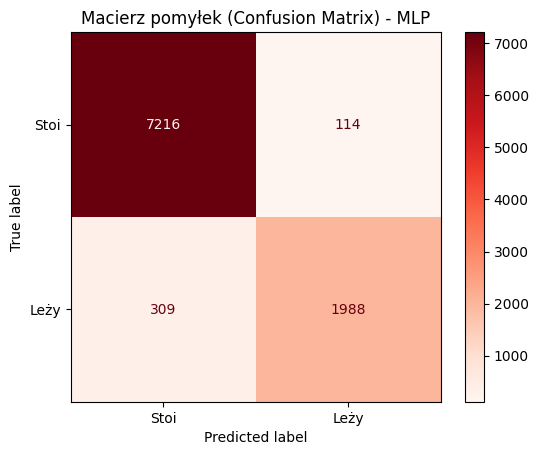

In [7]:
print(f"="*20+" MLP "+"="*20)

print(f"Średnia dokładnośc (accuracy):   {np.mean(accuracies_mlp):.3f}")
print(f"Średni Log Loss:   {np.mean(losses_mlp):.3f}")
print(f"Średni Recall:   {np.mean(recalls_mlp):.3f}")

print(f"\nRaport zbiorczy (z wszystkich testów):\n")
print(classification_report(all_y_trues_mlp, all_y_preds_mlp, target_names=['Stoi', 'Leży']))

# macierz pomyłek
cm_mlp = confusion_matrix(all_y_trues_mlp, all_y_preds_mlp)
ConfusionMatrixDisplay(cm_mlp, display_labels=['Stoi', 'Leży']).plot(cmap='Reds')
plt.title(f'Macierz pomyłek (Confusion Matrix) - MLP')
plt.show()

## Ogólne podsumowanie

In [19]:
from tabulate import tabulate

# Twoje dane
data = [
    ["Random Forest", round(np.mean(accuracies_rf), 3), round(np.mean(recalls_rf), 3), round(np.mean(losses_rf), 3)],
    ["SVM", round(np.mean(accuracies_svm), 3), round(np.mean(recalls_svm), 3), round(np.mean(losses_svm), 3)],
    ["MLP", round(np.mean(accuracies_mlp), 3), round(np.mean(recalls_mlp), 3), round(np.mean(losses_mlp), 3)]
]

# Nagłówki
headers = ["Model", "Accuracy", "Recall", "Losses"]

# Wyświetlenie (format 'fancy_grid' jest bardzo estetyczny)
print(tabulate(data, headers=headers, tablefmt="fancy_grid"))

╒═══════════════╤════════════╤══════════╤══════════╕
│ Model         │   Accuracy │   Recall │   Losses │
╞═══════════════╪════════════╪══════════╪══════════╡
│ Random Forest │      0.967 │    0.61  │    0.11  │
├───────────────┼────────────┼──────────┼──────────┤
│ SVM           │      0.973 │    0.601 │    0.088 │
├───────────────┼────────────┼──────────┼──────────┤
│ MLP           │      0.968 │    0.595 │    0.152 │
╘═══════════════╧════════════╧══════════╧══════════╛
